In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import missingno as mno

In [2]:
df = pd.read_csv('../data/data_clean.csv', sep=',', encoding='latin-1')
df = df.drop(columns=['PAQ706'])
df = df.drop(columns = ['CDQ001', 'CDQ010', 'DIQ070', 'DBD100', 'highLDL'])

#variable choice to create dataset for missignness simulation

cols = ['SEQN','RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'RIDRETH3',
                 'DMDCITZN', 'DMDEDUC2', 'BMXLEG', 'BPXPULS',
                 'DIQ010', 'DIQ050', 'HIQ011', 'PAQ635', 
                 'PAQ650', 'PAQ665','PAD680', 'PAQ710', 'DR1TKCAL'] 

cont_cols = ['RIDAGEYR', 'BMXLEG', 'DR1TKCAL', 'PAD680']

df_nonmiss = df[cols] 

# Normalize continuous columns to standard Normal 
for cont_col in cont_cols: 
    df_nonmiss[cont_col] = (df_nonmiss[cont_col] - df_nonmiss[cont_col].mean()) / df_nonmiss[cont_col].std() 
    
np_nonmiss = df_nonmiss.to_numpy(copy=True, na_value=np.nan) # Convert dataframe to numpy array 

np_nonmiss = np_nonmiss[~np.isnan(np_nonmiss).any(axis=1), :] # delete rows with any missing values

seqn = np_nonmiss[:, 0] #record seqn for rows in df_nonmiss
np_nonmiss = np_nonmiss[:, 1:18] #remove seqn
print(np.shape(np_nonmiss)) 

cols = cols[1:]

(4749, 17)


/var/folders/_1/dc2yd0kn325bph09grgy33lr0000gn/T/ipykernel_99530/597746274.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonmiss[cont_col] = (df_nonmiss[cont_col] - df_nonmiss[cont_col].mean()) / df_nonmiss[cont_col].std()


In [3]:
p = 0.1
#MCAR

MCAR_data = np.copy(np_nonmiss) #init data

MCAR_missing_indices = np.random.choice( # randomly select values from length ie flat array 
    len(np_nonmiss.flatten()), 
    size=int(len(np_nonmiss.flatten())*p)) 
MCAR_data.flat[MCAR_missing_indices] = np.nan

MCAR_data.shape

(4749, 17)

In [4]:
MNAR_data = np.copy(np_nonmiss) #init data

#find bmi values
bmi = df.loc[df['SEQN'].isin(seqn)]['bmi'] #limit to subset in seqn, select col bmi
bmi = bmi.to_numpy(copy=True, na_value=np.nan)

#high bmi
hibmi = (bmi > 25) #def of obesity
#health bmi
hebmi = (bmi < 25)

#determine indicies with hi or low bmi values
hibmi_ind = np.where(hibmi)[0]
hebmi_ind = np.where(hebmi)[0]

#randomly select indices for missing values
MNAR_missing_diet_ind = np.random.choice(len(hibmi_ind),
                                        size = round(len(hibmi_ind)*2*p/3)) #oversample hi bmi
np.append(MNAR_missing_diet_ind, 
          np.random.choice(len(hebmi_ind),
                           size = round(len(hebmi_ind)*p/3))) 

#remove those values from dataset
for i in MNAR_missing_diet_ind: 
    MNAR_data[i, 16] = np.nan #16 col is DR1TKCAL


In [5]:
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

In [6]:
def run(data, cols, method='stochastic'): 
    df = pd.DataFrame(data, columns=cols)
     
    mno.matrix(df, figsize = (20, 6))
    missing_columns = cols 
    
    for feature in missing_columns:
        df[feature + '_imp'] = df[feature]
        df = random_imputation(df, feature) 


    if method == 'deterministic': 
        deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])
        for feature in missing_columns:

            deter_data["Det" + feature] = df[feature + "_imp"]
            parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})

            #Create a Linear Regression model to estimate the missing data
            model = linear_model.LinearRegression()
            model.fit(X = df[parameters], y = df[feature + '_imp'])

            #observe that I preserve the index of the missing data from the original dataframe
            deter_data.loc[df[feature].isnull(), "Det" + feature] = \
                            model.predict(df[parameters])[df[feature].isnull()]

#         mno.matrix(deter_data, figsize = (20,5))

        sns.set()
        fig, axes = plt.subplots(nrows = 2, ncols = 2)
        fig.set_size_inches(8, 8)

        for index, variable in enumerate([cols[0], cols[1]]):
            sns.distplot(df[variable].dropna(), kde = False, ax = axes[index, 0])
            sns.distplot(deter_data["Det" + variable], kde = False, ax = axes[index, 0], color = 'red')

            sns.boxplot(data = pd.concat([df[variable], deter_data["Det" + variable]], axis = 1),
                        ax = axes[index, 1])

        plt.tight_layout() 
        return deter_data 

    if method == 'stochastic': 
        random_data = pd.DataFrame(columns = ["Ran" + name for name in missing_columns])

        for feature in missing_columns:

            random_data["Ran" + feature] = df[feature + '_imp']
            parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})

            model = linear_model.LinearRegression()
            model.fit(X = df[parameters], y = df[feature + '_imp'])

            #Standard Error of the regression estimates is equal to std() of the errors of each estimates
            predict = model.predict(df[parameters])
            std_error = (predict[df[feature].notnull()] - df.loc[df[feature].notnull(), feature + '_imp']).std()

            #observe that I preserve the index of the missing data from the original dataframe
            random_predict = np.random.normal(size = df[feature].shape[0], 
                                              loc = predict, 
                                              scale = std_error)
            random_data.loc[(df[feature].isnull()) & (random_predict > 0), "Ran" + feature] = \
                                    random_predict[(df[feature].isnull()) & (random_predict > 0)] 
            
        sns.set()
        fig, axes = plt.subplots(nrows = 2, ncols = 2)
        fig.set_size_inches(8, 8)

        for index, variable in enumerate([cols[0], cols[-1]]):
            sns.distplot(df[variable].dropna(), kde = False, ax = axes[index, 0])
            sns.distplot(random_data["Ran" + variable], kde = False, ax = axes[index, 0], color = 'red')
#             axes[index, 0].set(xlabel = variable + " / " + variable + '_imp')

            sns.boxplot(data = pd.concat([df[variable], random_data["Ran" + variable]], axis = 1),
                        ax = axes[index, 1])

        plt.tight_layout() 
        return random_data

/Users/nikunjgupta/work/virtualenvs/mtds/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nikunjgupta/work/virtualenvs/mtds/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


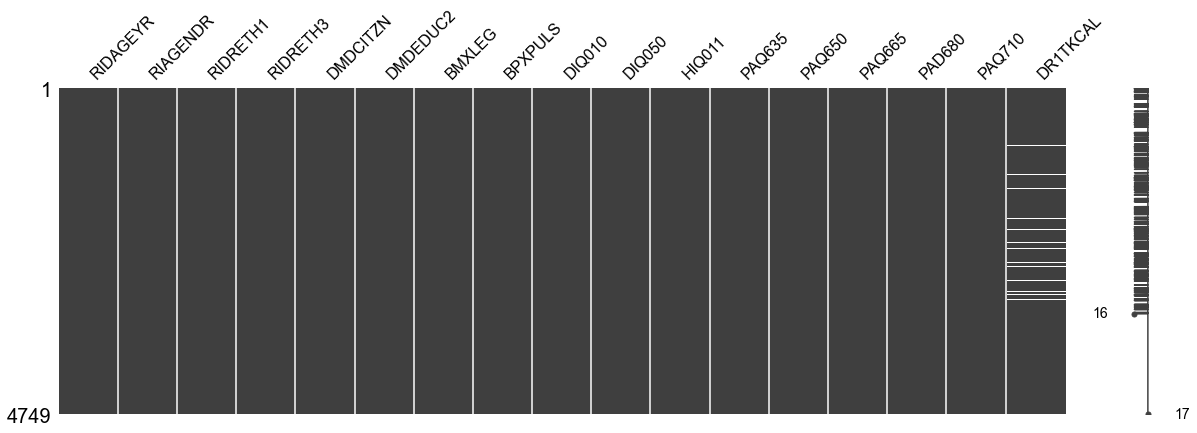

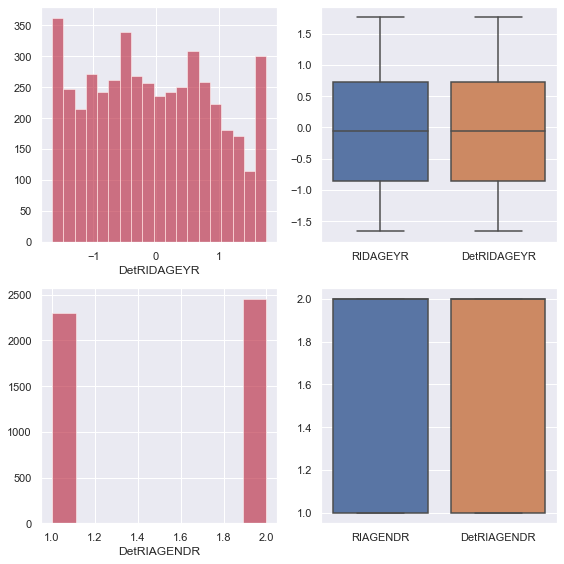

In [7]:
deter_data = run(MNAR_data, cols, method='deterministic') 

In [8]:
print(mean_squared_error(np_nonmiss.flat[MNAR_missing_diet_ind], deter_data.to_numpy().flat[MNAR_missing_diet_ind]))

0.008490481303265929


In [9]:
np_nonmiss_df = pd.DataFrame(np_nonmiss, columns=deter_data.columns)
for col in deter_data.columns: 
    print(col, '\t', mean_squared_error(np_nonmiss_df[col].to_numpy(), deter_data[col].to_numpy()))

DetRIDAGEYR 	 0.0
DetRIAGENDR 	 0.0
DetRIDRETH1 	 0.0
DetRIDRETH3 	 0.0
DetDMDCITZN 	 0.0
DetDMDEDUC2 	 0.0
DetBMXLEG 	 0.0
DetBPXPULS 	 0.0
DetDIQ010 	 0.0
DetDIQ050 	 0.0
DetHIQ011 	 0.0
DetPAQ635 	 0.0
DetPAQ650 	 0.0
DetPAQ665 	 0.0
DetPAD680 	 0.0
DetPAQ710 	 0.0
DetDR1TKCAL 	 0.03233447260389887


/Users/nikunjgupta/work/virtualenvs/mtds/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nikunjgupta/work/virtualenvs/mtds/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


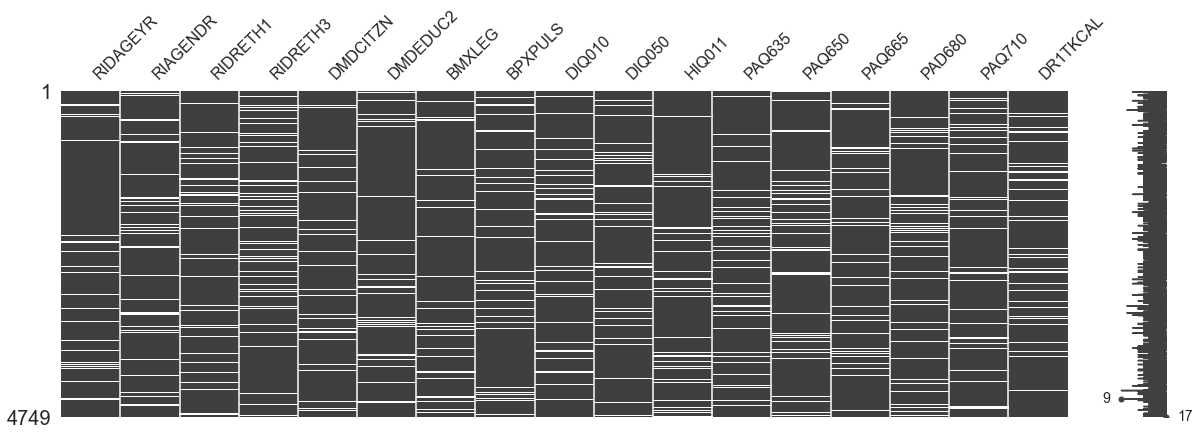

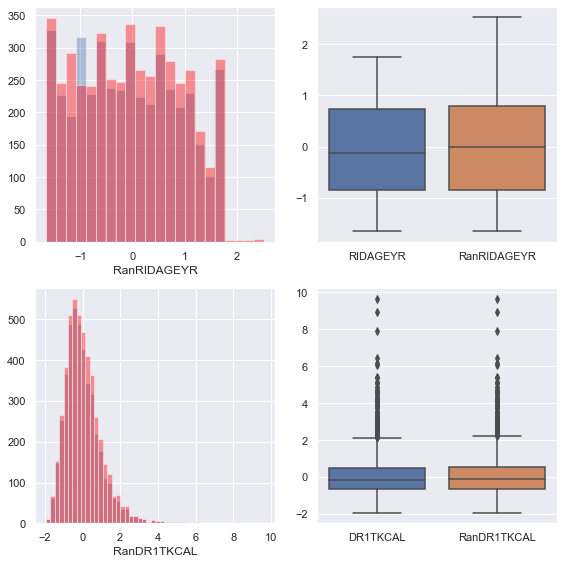

In [10]:
random_data = run(MCAR_data, cols, method='stochastic') 

In [11]:
print(mean_squared_error(np_nonmiss.flat[MCAR_missing_indices], random_data.to_numpy().flat[MCAR_missing_indices])) 

1.1127558741912589


In [12]:
np_nonmiss_df = pd.DataFrame(np_nonmiss, columns=random_data.columns)
for col in random_data.columns: 
    print(col, '\t', mean_squared_error(np_nonmiss_df[col].to_numpy(), random_data[col].to_numpy()))

RanRIDAGEYR 	 0.16606745468113118
RanRIAGENDR 	 0.03640751568351201
RanRIDRETH1 	 0.04702750701400768
RanRIDRETH3 	 0.08502815806707181
RanDMDCITZN 	 0.01941621057650923
RanDMDEDUC2 	 0.20228843021745557
RanBMXLEG 	 0.15120801162882408
RanBPXPULS 	 0.00330921118234596
RanDIQ010 	 0.024820236169236398
RanDIQ050 	 0.005837068782719441
RanHIQ011 	 0.02915379529164091
RanPAQ635 	 0.03277769319501184
RanPAQ650 	 0.02979675991268362
RanPAQ665 	 0.044672731789279926
RanPAD680 	 0.20764199676067135
RanPAQ710 	 0.5690241397377507
RanDR1TKCAL 	 0.15278623764670418


In [13]:
np_nonmiss_df.RanDR1TKCAL

0      -0.525435
1       2.842939
2      -0.362231
3      -0.673188
4      -0.321672
          ...   
4744   -0.862466
4745    0.060747
4746    0.303138
4747    2.480800
4748    0.344664
Name: RanDR1TKCAL, Length: 4749, dtype: float64

In [14]:
random_data.RanDR1TKCAL

0      -0.525435
1       2.842939
2      -0.362231
3      -0.673188
4       0.455230
          ...   
4744   -0.862466
4745    0.060747
4746    0.303138
4747    2.480800
4748    0.344664
Name: RanDR1TKCAL, Length: 4749, dtype: float64